# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.121631,True,6.257028
1,0.658344,False,3.059273
2,1.844799,True,6.900892
3,0.461885,True,6.053034
4,2.506200,True,7.845425
...,...,...,...
995,0.173669,False,0.148891
996,-0.133935,False,-1.114377
997,0.378183,True,5.318726
998,0.431475,True,7.346879


<AxesSubplot:xlabel='v0'>

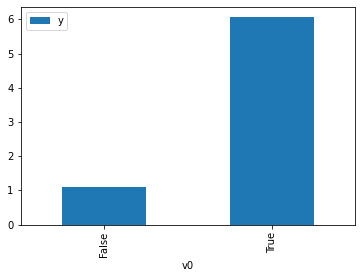

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

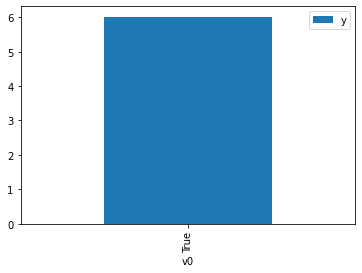

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.041332,False,1.527358,0.334075,2.993341
1,1.471706,False,1.042769,0.284555,3.514262
2,0.908297,False,2.267092,0.350226,2.855299
3,1.638731,False,2.492324,0.266573,3.751322
4,0.833440,False,1.395589,0.359470,2.781871
...,...,...,...,...,...
995,0.920315,False,-0.550921,0.348752,2.867366
996,1.039789,False,-0.277902,0.334260,2.991683
997,2.093442,False,1.878053,0.221426,4.516190
998,-0.068251,False,-0.593771,0.477205,2.095535


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.361622,True,2.621245,0.483252,2.069314
1,1.007593,True,7.852687,0.661864,1.510885
2,0.157642,True,3.108021,0.553075,1.808074
3,0.899288,True,5.564904,0.648667,1.541623
4,1.194135,True,7.744064,0.684006,1.461976
...,...,...,...,...,...
995,1.088137,True,6.463285,0.671519,1.489162
996,0.964516,True,6.671230,0.656644,1.522896
997,0.016164,True,5.926538,0.534142,1.872161
998,-0.078306,True,4.497298,0.521441,1.917761


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.319e+04
Date:                Wed, 27 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:33:13   Log-Likelihood:                         -1416.2
No. Observations:                1000   AIC:                                      2836.
Df Residuals:                     998   BIC:                                      2846.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1116      0.030     36.567      0.000       1.052       1.171
x2             4.9687      0.052     95.287      0.000       4.866       5.071
==============================================================================
Omnibus:                        2.725   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                2.393
Skew:                          -0.023   Prob(JB):                        0.302
Kurtosis:                       2.765   Cond. No.                         2.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""